In [13]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from pathlib import Path
import pandas as pd

# ссылка на датасет с картинками
# https://drive.google.com/drive/folders/1GKlE4GzOrRrzW9NhT8FMEDp2yAwMvo8o?usp=sharing

# перейти по ссылке,
# на своем диске раздел "Доступные мне",
# нажать три точки на папке,
# "Систематизировать" -> "Добавить ярлык" -> "Colab Notebooks"

In [14]:
from google.colab import drive
drive.mount('/content/drive')

# появится окну с предоставлением доступа - принять все

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [15]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [16]:
data_path = '/content/drive/MyDrive/Colab Notebooks/clothes-segmentation-dataset'
os.listdir(data_path)

['dataset.csv', '.DS_Store', 'crops', 'images']

In [17]:
# получить пути на двух папок и файла

IMAGES_PATH = os.path.join(data_path, "images")
CROPS_PATH = os.path.join(data_path, "crops")
CSV_PATH = os.path.join(data_path, "dataset.csv")

print(os.listdir(IMAGES_PATH)[0])
print(sorted(os.listdir(CROPS_PATH))[0])

img_0040 (1).jpeg
img_0001_crop_0.jpeg


📝 Задание 0

👉 Посмотри, какие файлы лежат в папках images и crops.
Сколько там файлов?

In [18]:
# Как посчитать программно, сколько файлов в каждой папке?
# Подсказка - воспользуйтесь len()

# print(...)

In [19]:
# df от DataFrame (в библиотеке Pandas представляет таблицу)

df = pd.read_csv(CSV_PATH)

print(df.head(5))
print()
print(df.tail(3))

   id     full_image          object_image category
0   1  img_0001.jpeg  img_0001_crop_0.jpeg     vest
1   2  img_0001.jpeg  img_0001_crop_1.jpeg   blouse
2   3  img_0002.jpeg  img_0002_crop_0.jpeg    dress
3   4  img_0002.jpeg  img_0002_crop_1.jpeg   jacket
4   5  img_0003.jpeg  img_0003_crop_0.jpeg     coat

        id     full_image          object_image category
1730  1731  img_0999.jpeg  img_0999_crop_0.jpeg    pants
1731  1732  img_0999.jpeg  img_0999_crop_1.jpeg      top
1732  1733  img_1000.jpeg  img_1000_crop_0.jpeg   romper


In [20]:
# кортеж с размерностью таблицы:
# (количество строк, количество столбцов).

print(df.shape)

# выводит список названий всех столбцов
# (индекс с именами колонок)

print(df.columns)

(1733, 4)
Index(['id', 'full_image', 'object_image', 'category'], dtype='object')


📝 Задание 1

Сколько всего строк в датасете?

Почему строк больше, чем фотографий в images?**Текст, выделенный полужирным шрифтом**

In [21]:
# уникальные категории

print(df["category"])
print()
print(df["category"].unique())

0            vest
1          blouse
2           dress
3          jacket
4            coat
          ...    
1728         cape
1729    stockings
1730        pants
1731          top
1732       romper
Name: category, Length: 1733, dtype: object

['vest' 'blouse' 'dress' 'jacket' 'coat' 'pants' 'cape' 'blazer' 'skirt'
 'suit' 'shoes' 'bag' 'jeans' 'shirt' 'stockings' 'romper' 'sweater'
 't-shirt' 'bodysuit' 'hat' 'sweatshirt' 'scarf' 'leggings' 'pumps'
 'hoodie' 'shorts' 'cardigan' 'jumper' 'tights' 'boots' 'top']


In [22]:
# сколько каждого типа одежды

category_counts = df["category"].value_counts().head(10)
category_counts

,count
category,
pants,284
dress,252
coat,224
jeans,143
blouse,94
skirt,90
suit,86
blazer,79
sweater,60


In [23]:
(
    df
    .groupby('category')
    .size()
    .sort_values(ascending=False)
).head(10)

,0
category,
pants,284
dress,252
coat,224
jeans,143
blouse,94
skirt,90
suit,86
blazer,79
sweater,60


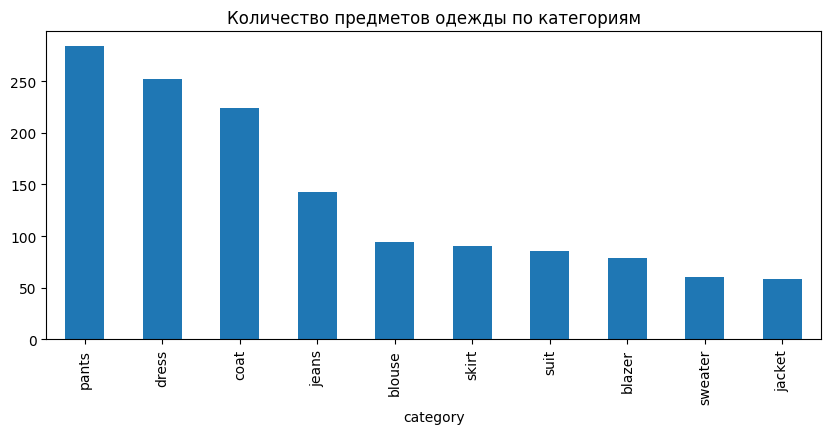

In [24]:
# визуализация

category_counts.plot(kind="bar", figsize=(10, 4))
plt.title("Количество предметов одежды по категориям")
plt.show()

# bar, barh, pie, area - типы диаграм

id                                13
full_image             img_0007.jpeg
object_image    img_0007_crop_0.jpeg
category                       skirt
Name: 12, dtype: object


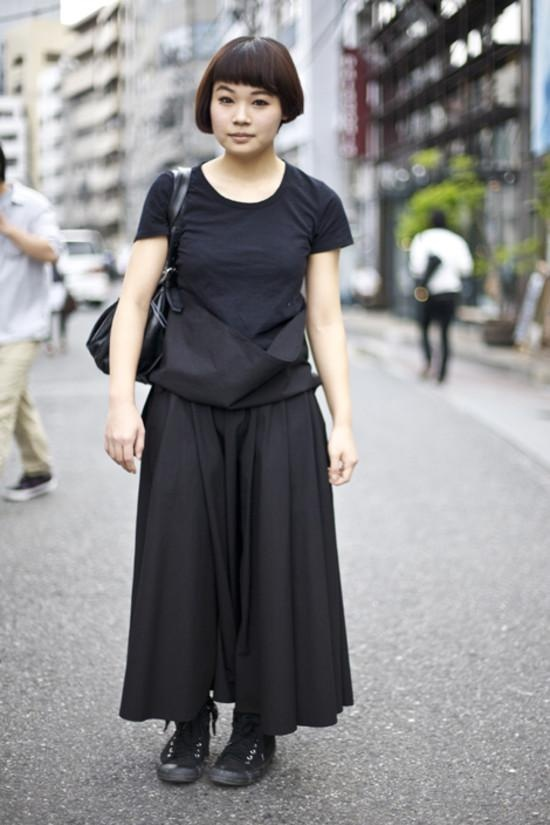

In [25]:
# поиск записи и определенной картинки

print(df.iloc[12])

Image.open(os.path.join(IMAGES_PATH, 'img_0007.jpeg'))
# Image.open(os.path.join(CROPS_PATH, 'img_0007_crop_0.jpeg'))

In [30]:
import os
import pickle
import numpy as np
import pandas as pd
from PIL import Image
try:
    import torch
    from transformers import SigLIPVisionModel, SigLIPImageProcessor
    from sklearn.metrics.pairwise import cosine_similarity
    TORCH_AVAILABLE = True
except ImportError as e:
    print(f"Error importing required libraries: {e}")
    print("Please install dependencies: pip install -r requirements.txt")
    print("And ensure Microsoft Visual C++ Redistributable is installed on Windows.")
    TORCH_AVAILABLE = False

if not TORCH_AVAILABLE:
    exit(1)

# Load dataset
try:
    df = pd.read_csv('dataset.csv')
except FileNotFoundError:
    print("dataset.csv not found. Ensure it is in the same directory as the script.")
    print("Current directory:", os.getcwd())
    print("Files in directory:", os.listdir('.'))
    exit(1)

# Directories
crops_dir = 'crops'
images_dir = 'images'

# Load model
try:
    model = SigLIPVisionModel.from_pretrained("google/siglip-base-patch16-224")
    processor = SigLIPImageProcessor.from_pretrained("google/siglip-base-patch16-224")
    model.eval()
except Exception as e:
    print(f"Error loading SigLIP model: {e}")
    print("Ensure transformers is updated to >=4.35.0")
    exit(1)

def get_embedding(image_path):
    image = Image.open(image_path).convert('RGB')
    inputs = processor(images=image, return_tensors="pt")
    with torch.no_grad():
        outputs = model(**inputs)
    return outputs.pooler_output.squeeze().numpy()

# Load or compute embeddings
embeddings_file = 'embeddings.pkl'
if os.path.exists(embeddings_file):
    with open(embeddings_file, 'rb') as f:
        embeddings = pickle.load(f)
else:
    embeddings = {}
    for idx, row in df.iterrows():
        img_path = os.path.join(crops_dir, row['object_image'])
        if os.path.exists(img_path):
            emb = get_embedding(img_path)
            embeddings[row['id']] = emb
    with open(embeddings_file, 'wb') as f:
        pickle.dump(embeddings, f)

# User image path (change this to the user's image)
user_img_path = 'images/user_image.jpg'  # Replace with actual path

if os.path.exists(user_img_path):
    try:
        user_emb = get_embedding(user_img_path)
    except Exception as e:
        print(f"Error processing user image: {e}")
        exit(1)

    # Compute similarities
    similarities = {}
    for id_, emb in embeddings.items():
        sim = cosine_similarity([user_emb], [emb])[0][0]
        similarities[id_] = sim

    # Top 5ыкк
    top5 = sorted(similarities.items(), key=lambda x: x[1], reverse=True)[:5]
    print("Top 5 similar product IDs:", [id_ for id_, _ in top5])
else:
    print("User image not found. Please add the image to the images folder and update the path.")

Error importing required libraries: cannot import name 'SigLIPVisionModel' from 'transformers' (/usr/local/lib/python3.12/dist-packages/transformers/__init__.py)
Please install dependencies: pip install -r requirements.txt
And ensure Microsoft Visual C++ Redistributable is installed on Windows.
dataset.csv not found. Ensure it is in the same directory as the script.
Current directory: /content
Files in directory: ['.config', 'drive', 'embeddings.pkl', 'sample_data']
Error loading SigLIP model: name 'SigLIPVisionModel' is not defined
Ensure transformers is updated to >=4.35.0
User image not found. Please add the image to the images folder and update the path.
